In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import backtest
import data
import evaluation

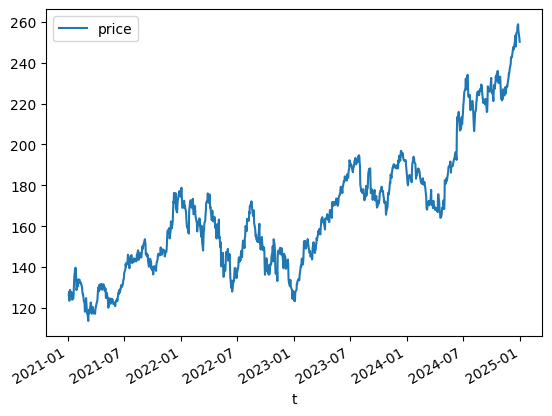

In [2]:
price_df = data.load_hist_data()
price_df.plot(x='t', y='price')
plt.show()

In [3]:
def ma_price_diff_signal(price_df, period=50):
    signal = np.sign(price_df['price'] - price_df['price'].rolling(period).mean()).fillna(0)
    return pd.DataFrame({'t': price_df['t'], 'signal': signal})


def hold_long_signal(price_df):
    signal = np.ones_like(price_df['price'])
    return pd.DataFrame({'t': price_df['t'], 'signal': signal})

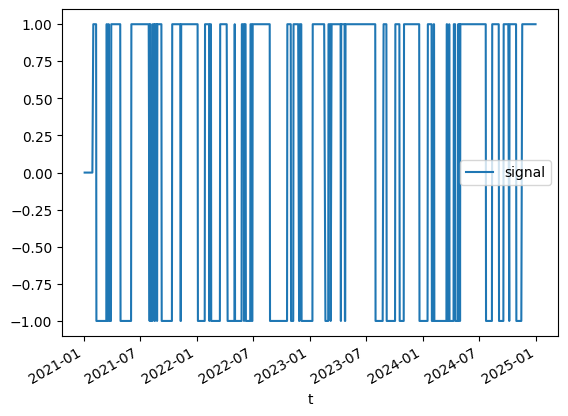

,t,signal
0,2021-01-04,1.0
1,2021-01-05,1.0
2,2021-01-06,1.0
3,2021-01-07,1.0
4,2021-01-08,1.0


In [4]:
signal_df = ma_price_diff_signal(price_df, period=20)
signal_df.plot(x='t', y='signal')
plt.show()

long_signal_df = hold_long_signal(price_df)
long_signal_df.head()

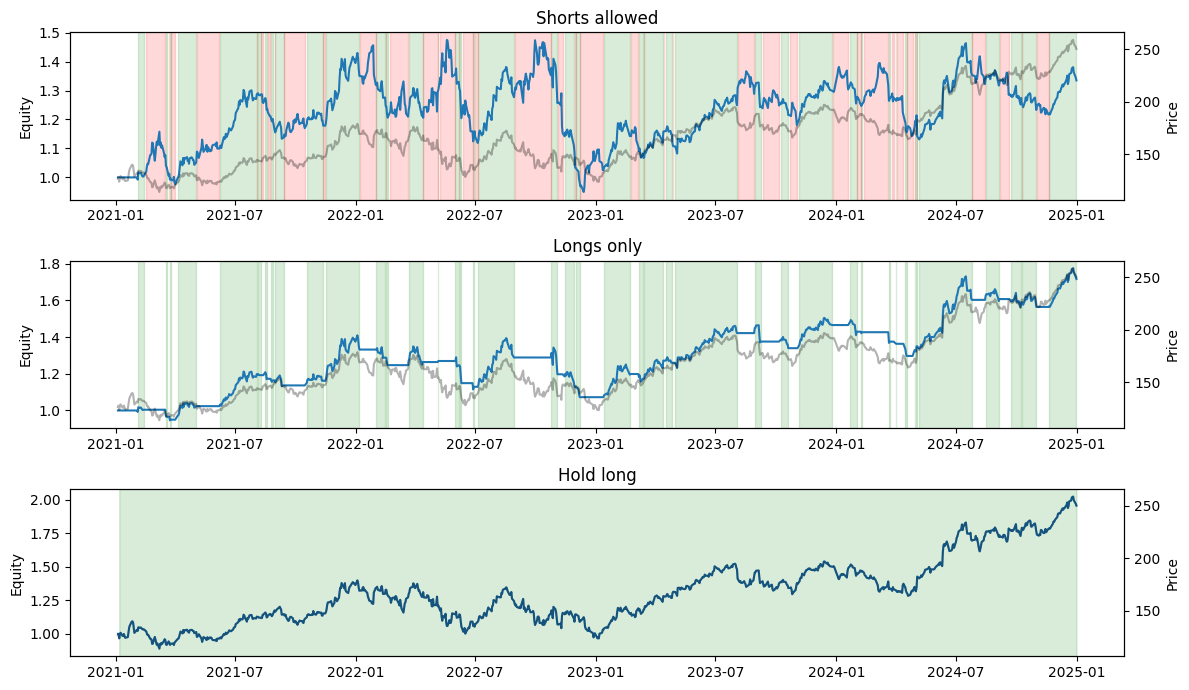

In [5]:
settings_dct = {
    'Shorts allowed': (True, signal_df),
    'Longs only': (False, signal_df),
    'Hold long': (False, long_signal_df)
}
spread = 0.0002
return_df_dct = {}

fig, axes = plt.subplots(3, 1, figsize=(12, 7))
for setting, ax in zip(settings_dct, axes.flatten()):
    ax2 = ax.twinx()
    return_df = backtest.backtester(price_df, settings_dct[setting][1], spread=spread, spread_is_relative=True, allow_shorts=settings_dct[setting][0])
    evaluation.draw_results(ax, ax2, return_df, price_df, fig_title=setting)
    return_df_dct[setting] = return_df

plt.tight_layout()
plt.show()

In [6]:
stats_dct = {}
for setting, return_df in return_df_dct.items():
    trade_df = backtest.build_trade_pairs(return_df)
    evaluation.assert_pnl_invariant(return_df, trade_df)
    stats_dct[setting] = evaluation.generate_stats_report(return_df, trade_df)
pd.DataFrame({setting: evaluation.format_stats_for_display(dct) for setting, dct in stats_dct.items()})

,Shorts allowed,Longs only,Hold long
Resulting Equity,1.335,1.716,1.955
Annualized Sharpe ratio,0.408,0.862,0.765
"Maximum drawdown magnitude, equity units",0.525,0.337,0.432
"Maximum drawdown duration, bars",657,372,354
Number of trades,83,83,1
Number of closed positions,82,41,0
"Average position holding period, bars",16.9,19.3,NaN
Win rate,39%,39%,NaN


Here we compare a simple signal based on the difference between price and its moving average to a baseline strategy that continuously holds a long position in a stock with a strong bullish trend. For the signal-based strategy, we additionally compare allowing the strategy to open short positions versus restricting it to only create long positions. The long-only variant of the signal-based strategy performs better across all reported statistics. This is expected, as such a simple signal is not reliable enough to generate profitable short positions for an asset with a strong positive trend. Continuously holding the stock results in a higher final equity value than the long-only signal-induced strategy, but at the cost of higher return volatility and, consequently, a lower Sharpe ratio. In contrast, the long-only signal-induced strategy spends time out of the market, which reduces return variance and improves risk-adjusted performance despite lower total equity.